# The standard incomplete markets model: dynamics, sequence-space Jacobians, and second moments

NBER Heterogeneous-Agent Macro Workshop

Matthew Rognlie

Spring 2023

# Last lecture
- Learned how to compute standard incomplete markets model in **steady state**


- For steady state, briefly covered calibration, general equilibrium, and computing individual-level expectations


- Code we wrote combined into `sim_steady_state.py` module, we'll load a version with some speed improvements, `sim_steady_state_fast.py`, and calculate its steady state:

In [1]:
import sim_steady_state_fast as sim
ss = sim.steady_state(**sim.example_calibration())

# Preliminaries
As usual, before we start we'll also need to import the Python libraries that we'll directly be using:

In [92]:
import numpy as np
import numba
from scipy import optimize
import matplotlib.pyplot as plt

# some useful plot defaults
plt.rcParams.update({'font.size' : 20, 'lines.linewidth' : 3.5, 'figure.figsize' : (13,7)})

# These lectures: dynamics away from steady state
1. **Partial equilibrium**: how do households respond to a shock to real interest rates or income?


2. **General equilibrium**: in response to some shock, how do we find path of, say, real interest rates that clears the asset market?


3. **Sequence-space Jacobians and the fake news algorithm**: key technical innovation that facilitates rapidly solving for general equilibrium


4. **Linear impulse responses, simulation and second moments**: computing stochastic economy from first-order impulse response functions, using aggregate certainty equivalence

**aggregate certainty equivalence**: It means that the coefficients of the linear policy rules do not depend on the second-order moments of the shock processes. In other words, an unexpected shock is equivalent to an expected shock with zero mean but some variation (as the second moment is irrelevant).

# Partial equilibrium

# Partial equilibrium impulse responses
- Suppose household faces a time-varying sequence ${r_t}$ or ${y_t(e)}$, deviating from steady-state values


- Our existing backward and forward iteration routines apply to one period apiece, and can handle time-varying inputs


- But two assumptions needed for practicality:
    * **Terminal condition** for backward iteration: at some $T$, we know marginal value $V_{aT}$
    * **Initial condition** for forward iteration: we know incoming distribution $D_0$
    
    
- Most common assumption is that both are steady state
    * For terminal condition, can justify if shocks have disappeared and inputs are back to steady state by $T$
    * For initial condition, can justify if shock away from steady state is unexpected, and households assumed everything would stay at steady state, so that they maintained steady-state policies and distribution, until learning at date 0 of a different path - this is a so-called **MIT shock**

- **Notes**
  * We consider perfect foresight for the whole path of shock in this time.
  * First, given $V_{aT}$, we solve for all policy functions by backward iteration. Then, given $D_0$, using forward iteration, we solve for the distributions.

# Partial equilibrium: backward iteration to obtain policy function
- Let's assume that at date 5, all incomes $y(e)$ will go up for one period by 1%

In [93]:
T = 100 # we'll calculate household responses up to T
ys = np.outer(1 + 0.01*(np.arange(T) == 5), ss['y'])

In [94]:
ys.shape

(100, 7)

Here, $ys$ consists of all income possibilites in all times between 0 and 11. Notice that we have a 1 percent shock at time 5.

- Iterate backward and store asset and consumption policies as we go:

In [95]:
Va = ss['Va'] # initialize with steady-state marginal value function
a, c = [np.empty((T,) + ss['a'].shape) for _ in range(2)] # empty arrays to store a and c paths
ss_inputs = {k: ss[k] for k in ('Pi', 'a_grid', 'r', 'beta', 'eis')} # dict of non-changing ss inputs
for t in reversed(range(T)):
    Va, a[t], c[t] = sim.backward_iteration(Va=Va, y=ys[t], **ss_inputs)

# Partial equilibrium: plot policy functions
- Let's plot change in consumption policy at low, middle, and high income states and roughly average assets


- Note no change after $t=5$: that's because this is the *policy function* and does not track consumption of an individual household over time
    * We're looking at consumption policy given a certain level of assets at each date, so we're missing effect of savings from income at date 5
    * To understand actual path of consumption, need to do *forward iteration* to keep track of distribution as well

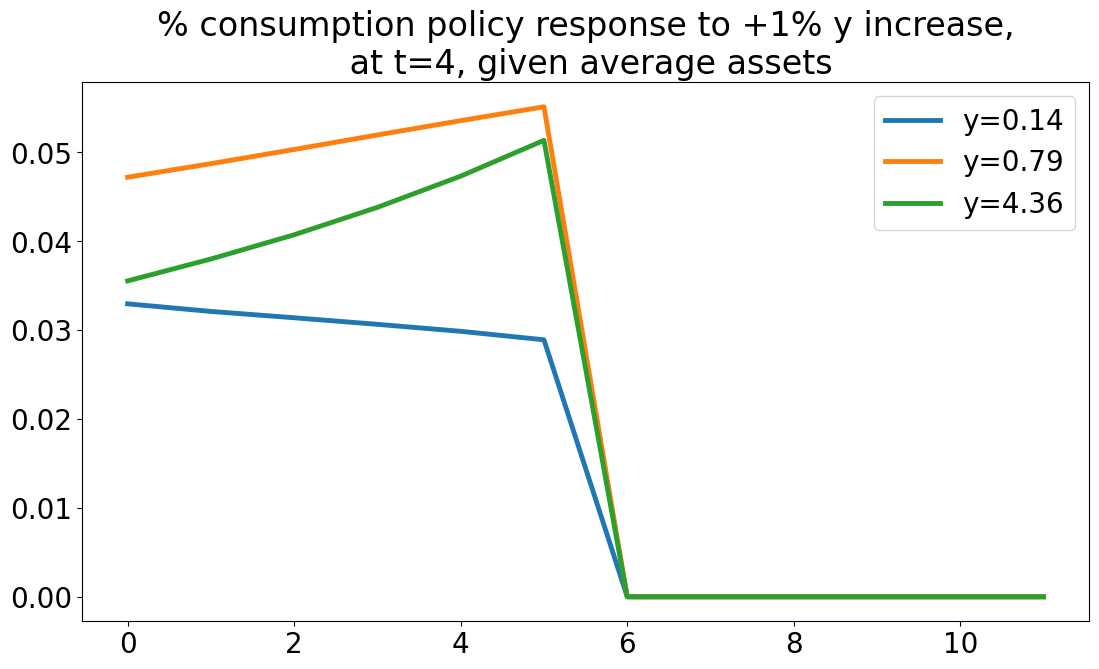

In [96]:
c_impulse = 100*(c - ss['c']) / ss['c'] # percent change in consumption policy function
i_ave = np.argmax(ss['a_grid'] > ss['A']) # first index of assets above average
for e in (0, 3, 6):
    plt.plot(c_impulse[:12, e, i_ave], label=f"y={ss['y'][e]:.2f}")
plt.legend()
plt.title(f"% consumption policy response to +1% y increase,\n at t=4, given average assets");

C:\Users\moham\AppData\Local\Temp\ipykernel_14192\1851504604.py:2: RuntimeWarning: divide by zero encountered in divide
  100 * (a - ss['a']) / ss['a']) # percent change in consumption policy function
C:\Users\moham\AppData\Local\Temp\ipykernel_14192\1851504604.py:2: RuntimeWarning: invalid value encountered in divide
  100 * (a - ss['a']) / ss['a']) # percent change in consumption policy function


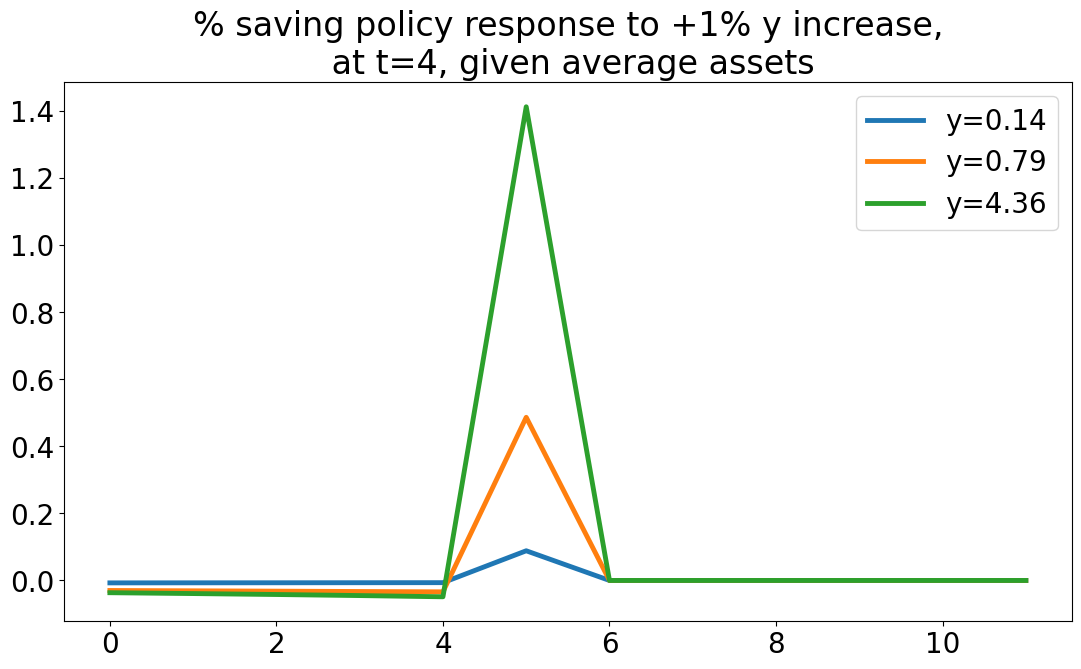

In [97]:
a_impulse = np.where(ss['a'] == 0, 0, \
    100 * (a - ss['a']) / ss['a']) # percent change in consumption policy function
i_ave = np.argmax(ss['a_grid'] > ss['A']) # first index of assets above average
for e in (0, 3, 6):
    plt.plot(a_impulse[:12, e, i_ave], label=f"y={ss['y'][e]:.2f}")
plt.legend()
plt.title(f"% saving policy response to +1% y increase,\n at t=4, given average assets");

# Partial equilibrium: forward iteration to obtain distribution
Initialize beginning-of-period distribution at date 0 to steady state ("MIT shock"):

In [98]:
D = np.empty_like(a)
D[0] = ss['D']

Now use our already-calculated asset policy function `a` over time to make updates:

In [99]:
for t in range(T-1):
    # use special function from sim module to get lottery for time-t policy
    a_i, a_pi = sim.interpolate_lottery_loop(a[t], ss['a_grid'])
    
    D[t+1] = sim.forward_iteration(D[t], ss['Pi'], a_i, a_pi)

Use this distribution to get aggregate consumption and end-of-period assets in each period:

In [100]:
A, C = np.empty(T), np.empty(T)
for t in range(T):
    A[t] = np.vdot(D[t], a[t])
    C[t] = np.vdot(D[t], c[t])

# Partial equilibrium: aggregate consumption and assets
- Now we can see full paths of aggregate consumption and assets in response to this change
    * Scale asset change by steady-state consumption so they're in same units


- **Due to high MPCs, biggest effect of 1% income increase is contemporaneous, but also an anticipatory effect and even more of a lagged effect**
    * Anticipatory spending draws down assets, lagged spending slowly draws down windfall from higher income

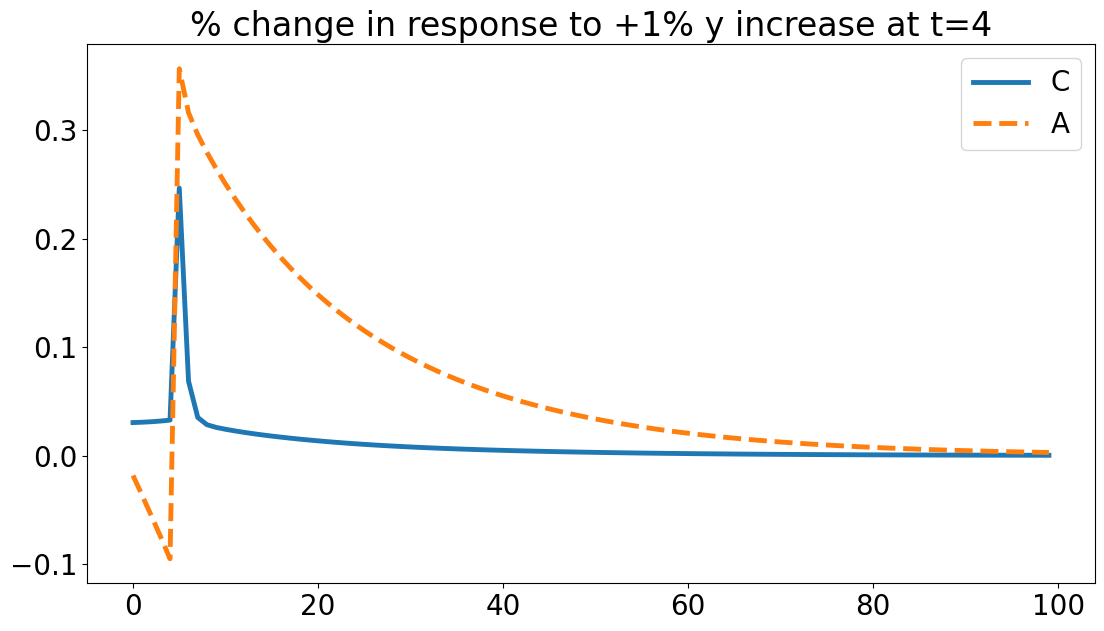

In [101]:
C_impulse = 100*(C - ss['C'])/ss['C']
A_impulse = 100*(A - ss['A'])/ss['A']
plt.plot(C_impulse, label='C')
plt.plot(A_impulse, '--', label='A')
plt.legend()
plt.title('% change in response to +1% y increase at t=4');

**Explanation:** With a positive one time shock in income, first, agents will increase their consumption. So, before the shock, the consumption would rise. Then, in the time of the shock, we have the biggest increase in consumption. After that, as everything is back to normal, the economy will converge back to ss consumption (aggregate level).

Also, for aggregate assets, saving would decrease before the shock, then, at the time of the shock, saving would drastically rise. Then, it will converge back to steady state. Notice that, according to our result, **aggregate asset get back to steady state slower than aggregate consumption**.

# Partial equilibrium: general code for any impulse (policy)
Can we encapsulate what we just did in a function? First, a function that spits out time-varying policies (and also the marginal value function) given *shocks* (deviations from steady state) to `y`, `r`, or `beta` in the dict `shocks`:

In [102]:
def policy_impulse(ss, shocks, T):
    # check that all values in "shocks" have first dimension T
    assert all(x.shape[0] == T for x in shocks.values())
    
    # extract inputs to backward_iteration function from ss
    inputs = {k: ss[k] for k in ('Va', 'Pi', 'a_grid', 'y', 'r', 'beta', 'eis')}
    
    # create a T*nS*nA array to store each outputs of backward iteration
    Va, a, c  = (np.empty((T,) + ss['Va'].shape) for _ in range(3))

    for t in reversed(range(T)):
        # add this period's perturbation to parameters that are shocked
        for k in ('y', 'r', 'beta'):
            if k in shocks:
                inputs[k] = ss[k] + shocks[k][t]
                
        Va[t], a[t], c[t] = sim.backward_iteration(**inputs)
        
        # use this Va for next iteration
        inputs['Va'] = Va[t]
        
    return Va, a, c

Apply to our shock to `y` and verify we get exactly the same answers (not even numerical error here, since we're using exactly the same approach):

In [103]:
_, a_alt, c_alt = policy_impulse(ss, {'y': ys - ss['y']}, T)
assert np.array_equal(a, a_alt) and np.array_equal(c, c_alt)

# Partial equilibrium: general code for any impulse (distribution and aggregates)
Distribution even easier, taking in time-varying asset policy function `a` and essentially copying what we did before:

In [104]:
def distribution_impulse(ss, a, T):
    assert a.shape[0] == T
    D = np.empty_like(a)
    D[0] = ss['D']
    
    for t in range(T-1):
        a_i, a_pi = sim.interpolate_lottery_loop(a[t], ss['a_grid'])
        D[t+1] = sim.forward_iteration(D[t], ss['Pi'], a_i, a_pi)
        
    return D

Now write a function that computes everything and returns full paths (if desired) and aggregates:

In [105]:
def household_impulse(ss, shocks, T):
    Va, a, c = policy_impulse(ss, shocks, T)
    D = distribution_impulse(ss, a, T)
    return dict(D=D, Va=Va, a=a, c=c, # time-varying stuff
                A=np.sum(a*D, axis=(1,2)), C=np.sum(c*D, axis=(1,2))) # aggregate everything else quickly

Test that this gives same results as what we had before:

In [106]:
impulse = household_impulse(ss, {'y': ys - ss['y']}, T)
assert np.max(np.abs(impulse['A'] - A)) < 5E-16 and np.max(np.abs(impulse['C'] - C)) < 5E-16

# Additional example: partial equilibrium consumption response to different return shocks
Let's do 1 percentage point shocks to $r$ at dates 0, 5, 10, 15

If shock at date 0, it's just a return surprise, but if at later dates, household consume less to build up assets in anticipation of higher $r$ (with smaller reaction if shock further in future), then spend down their saving

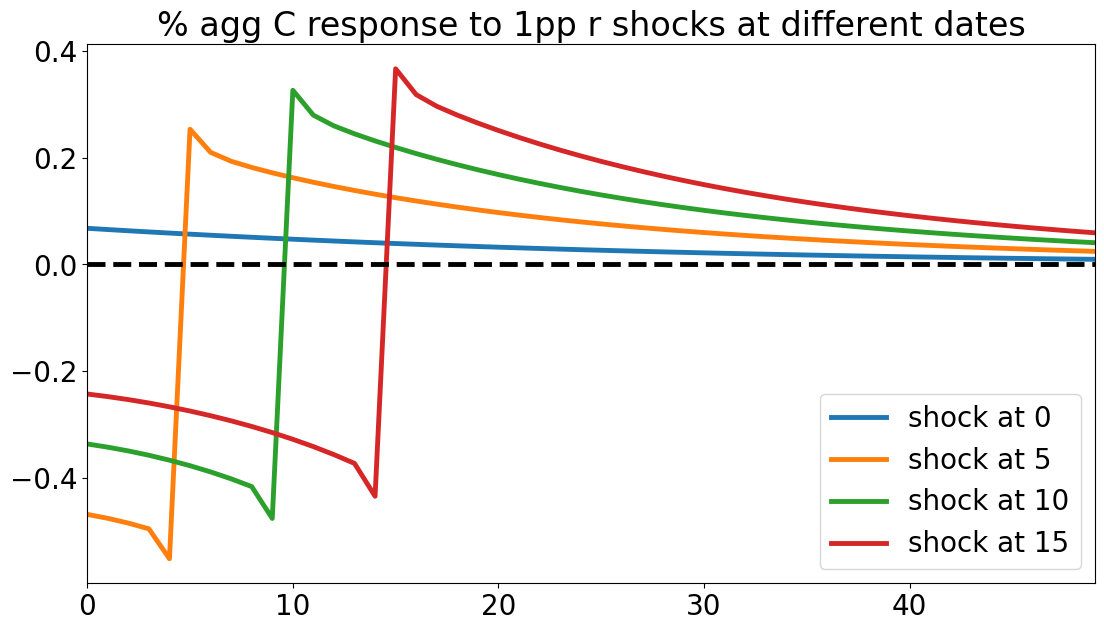

In [124]:
T = 50
for t in (0, 5, 10, 15):
    plt.plot(100*(household_impulse(ss, {'r': 0.01*(np.arange(T) == t)}, T)['C'] - ss['C'])/ss['C'],
                 label=f'shock at {t}')
plt.hlines(0, 0, T, linestyle='--', colors='k')
plt.xlim(0, T-1)
plt.legend()
plt.title('% agg C response to 1pp r shocks at different dates');

# General equilibrium

# General equilibrium impulse responses
- So far, we've confronted households with exogenous shocks to incomes or returns


- What if instead we shock a **general equilibrium economy** - where households have after-tax income $(Z_t-\tau_t)e$, where $\tau_t$ is a tax and $X_t$ is productivity equal to 1 in steady state, and then finding the real interest rate path that clears the market given constant government bonds?
    * Still considering an **MIT shock**: starting from the steady state, this change comes as a surprise at date 0
    

- Start by redoing the general equilibrium calibration from last lecture:

In [125]:
B = 5.6
tau = ss['r']*B
e = ss['y']

beta_ge = optimize.brentq(lambda beta: sim.steady_state(ss['Pi'], ss['a_grid'],
                                    (1-tau)*e, ss['r'], beta, ss['eis'])['A'] - B, 0.98, 0.995)
ss_ge = sim.steady_state(ss['Pi'], ss['a_grid'], (1-tau)*e, ss['r'], beta_ge, ss['eis'])
ss_ge['A'] - B # check asset market clearing

-1.6579626560542238e-11

- And choosing a shock to $X_t$, let's say a 1% AR(1) with persistence $\rho=0.95$

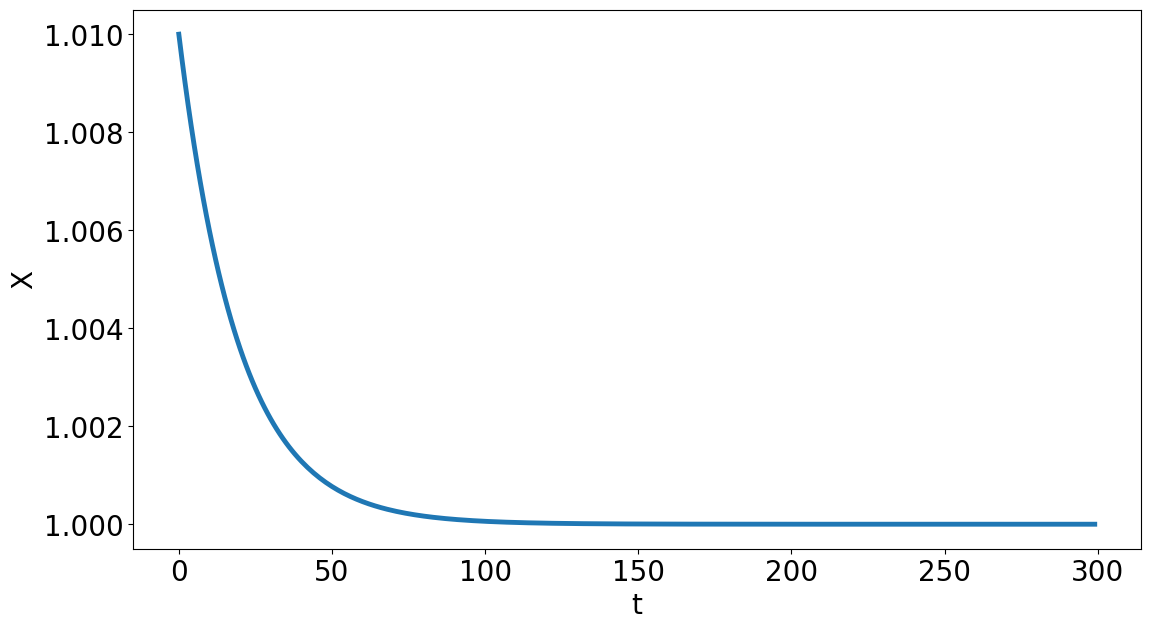

In [133]:
T = 300
Xs = 1 + 0.01*0.95**np.arange(T)
plt.plot(Xs)
plt.xlabel('t')
plt.ylabel('X');

# GE impulse responses: find $r$ path that hits asset market clearing
- In our GE economy, assets are government bonds


- Assume real interest rate on bonds held between $t$ and $t+1$ fixed at $r_t^{ante}$ ex-ante
    * In our household problem we denoted returns by date earned, so $r_{t+1} = r_t^{ante}$


- So if solving for GE impulse, we need to find path $(r_0^{ante}, r_1^{ante}, \ldots, r_{T-2}^{ante})$ of ex-ante real rates, or ex-post real rates $(r_1,\ldots,r_{T-1})$, such that asset market clearing is satisfied $0, \ldots, T-2$
    * assuming government sets $\tau_t = r_t B$ to balance budget
    * we say $(r_1,\ldots,r_{T-1})$ is our **unknown** and asset market clearing $0,\ldots, T-2$ is our **target**


- $\{r_t\}$ affects households
    * **directly** (earned on bonds held by households)
    * **indirectly** (paid out by government, which raises taxes to pay for them)

# Set up function mapping $r$ path to asset market clearing error, other household outcomes

In [139]:
pi = ss_ge['D'].sum(1) # steady-state distribution of s (unchanging)

def impulse_map(rs, Xs):
    # government budget balance at each date: tau_t = r_t*B (given average e=1) 
    taus = rs * B
    ys = np.outer(Xs - taus, e)
    
    # calculate household impulse
    impulse = household_impulse(ss_ge, {'r': rs - ss_ge['r'], 'y': ys - ss_ge['y']}, len(rs))
    
    return impulse['A'] - B, impulse

# What if r doesn't change?
If we hold r constant at the steady state, then clear initial excess of demand for assets (households trying to save) over supply of bonds (constant), as households try to consumption-smooth in response to temporary productivity increase

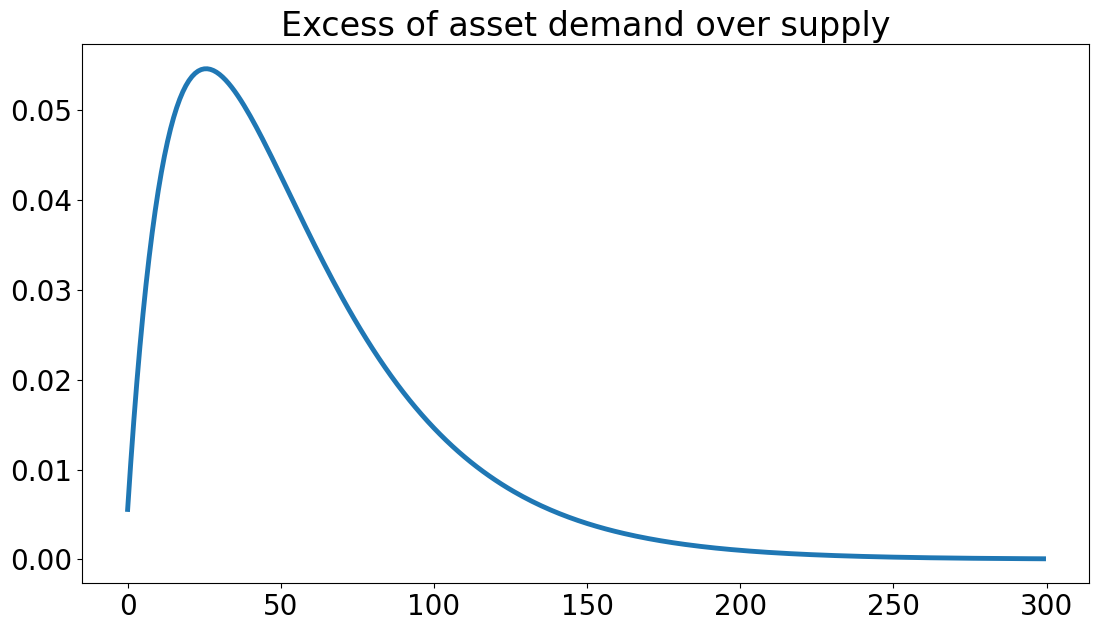

In [140]:
asset_mkt_error, _  = impulse_map(np.full(T, ss_ge['r']), Xs)
plt.plot(asset_mkt_error)
plt.title('Excess of asset demand over supply');

# Ad-hoc iteration on r to find equilibrium
If households are trying to save in too many assets between $t-1$ and $t$, let's inch down $r_t$ by an ad-hoc factor to encourage them not to save, and keep updating our guess. With a well-chosen factor, we can find a path of $r$ that *approximately* clears the asset market, but convergence excruciatingly slow, and we only get accuracy to even 0.0005 after about 140 iterations:

Converged to 0.0005 accuracy after 138 iterations


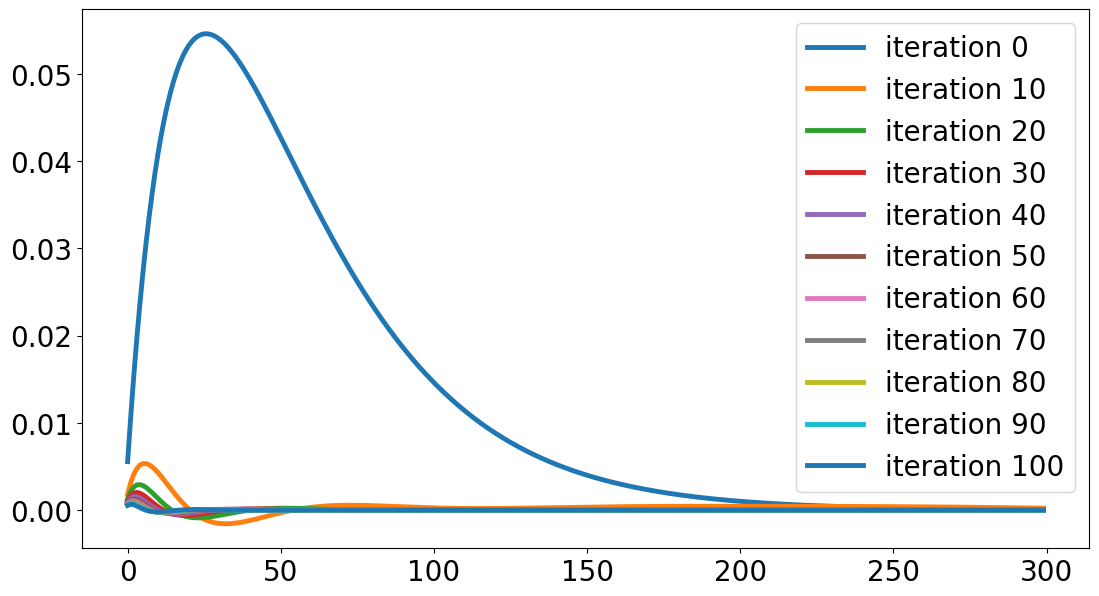

In [141]:
rs = np.full(T, ss_ge['r']) # initial guess constant
for it in range(400):
    asset_mkt_error, impulse = impulse_map(rs, Xs)
    if it % 10 == 0 and it <= 100:
        plt.plot(asset_mkt_error, label=f'iteration {it}')
    if np.max(np.abs(asset_mkt_error)) < 5E-4:
        print(f'Converged to 0.0005 accuracy after {it} iterations')
        break
    rs[1:] -= 0.002*asset_mkt_error[:-1] # remember: can't change rs[0], which was fixed here before date 0
plt.legend();

Text(0, 0.5, 'r')

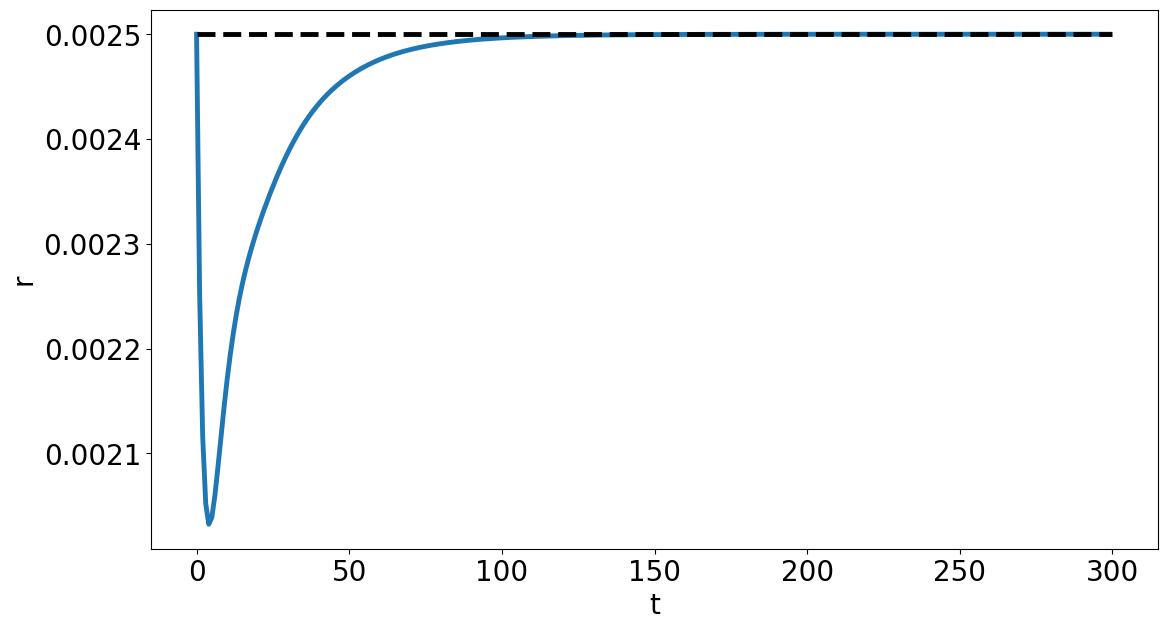

In [143]:
plt.plot(rs)
plt.hlines(ss_ge['r'], 0, T, linestyle='--', colors='k')
plt.xlabel('t')
plt.ylabel('r')

# Ad-hoc iteration: quickly explodes with too aggressive an adjustment!
Let's try 0.003 instead of 0.002 as our coefficient, otherwise doing the same adjustment as before. Things start to explode rather than converging to equilibrium!

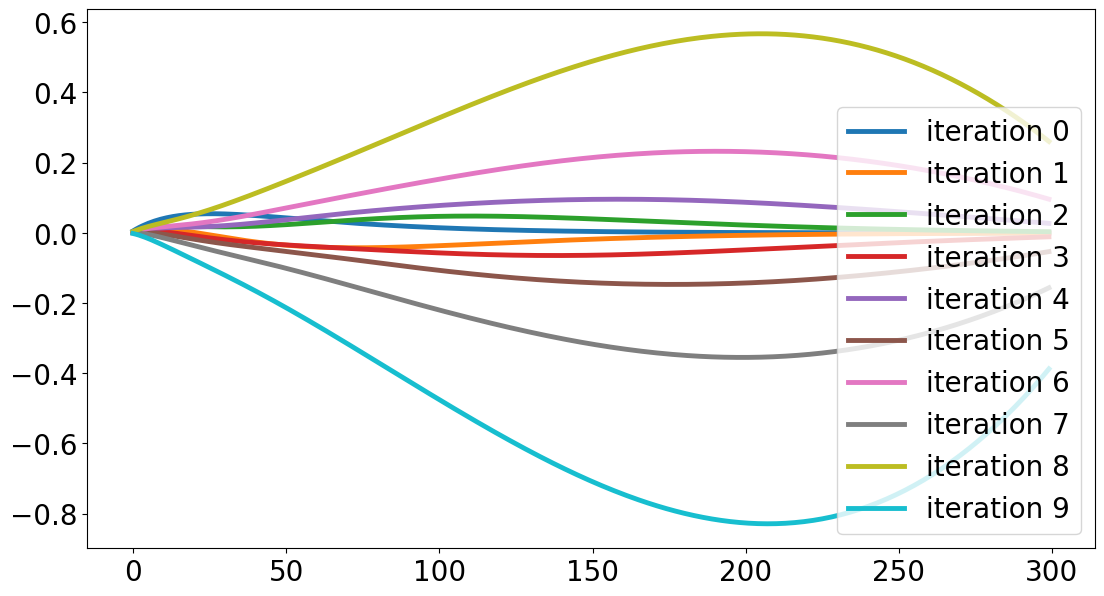

In [144]:
rs = np.full(T, ss_ge['r']) # initial guess constant
for it in range(10):
    asset_mkt_error, impulse = impulse_map(rs, Xs)
    plt.plot(asset_mkt_error, label=f'iteration {it}')
    rs[1:] -= 0.003*asset_mkt_error[:-1]
plt.legend();

# Ad-hoc iteration: doesn't work very well
- This is an extreme case, and in many other models or calibrations it works better
    * Bewley-style model with government bonds infamously bad, Aiyagari-style model with capital typically better
    
    
- Still, it's a fragile and awkward way to compute equilibrium!
    * Need to pick ad-hoc adjustment rule for guess and iterate hundreds or thousands of times
    * Adjustment rule that achieves convergence without explosion may vary from calibration to calibration
    * More awkward, verging on impossible, if you have more than one unknown to iterate over
    
    
- There's a better way: the sequence-space Jacobian!

# Sequence-space Jacobians to iterate over guesses
- Why is it so hard to update our guess for $r$ to achieve asset market clearing?


- It's because $r$ *impacts asset market clearing in a complex way*, and our simple adjustment rule only captures part of it


- If we had the *exact* mapping $\bar{\mathbf{J}}$, in the neighborhood of the steady state, from the real interest rate path $\mathbf{r}\equiv(r_1,\ldots,r_{T-1})$ to the asset demand path $\mathbf{A}\equiv (A_0,\ldots,A_{T-2})$, then we could update guesses using a version of **Newton's method**

$$
\mathbf{r}^n = \mathbf{r}^{n-1} - \bar{\mathbf{J}}^{-1}(\mathbf{A}^{n-1} - B)
$$


- This uses $\bar{\mathbf{J}}$ to tell us how to update our $n-1$th guess for $\mathbf{r}$ to our $n$th guess, given the asset market clearing error on the $n-1$th guess

# Brute-force ("direct") method to obtain sequence-space Jacobians
- Let $\mathbf{J}$ be the $T \times T$ Jacobian of our `impulse_map` function from $r$ to asset market clearing, using steady-state $X$
    * $\bar{\mathbf{J}}$ from last slide is this, taking out first column and last row
    
    
- Brute-force approach to calculate the entire $T \times T$ Jacobian by evaluating `impulse_map` on small shocks to $r$ at every horizon - here takes about 17 seconds

In [22]:
%%time
J = np.empty((T, T))
h = 1E-4 # small shock to r is 1E-4
no_shock = impulse_map(np.full(T, ss_ge['r']), 1)[0] # "ghost run" with no shock to subtract off
for tshock in range(T):
    J[:, tshock] = (impulse_map(ss_ge['r'] + h*(np.arange(T) == tshock), 1)[0] - no_shock) / h

CPU times: user 15.2 s, sys: 1.19 s, total: 16.4 s
Wall time: 16.8 s


- Each column gives the impact of a change in $r_s$ at some date on the path of assets. Can interpret as the impulse response to a **"news shock"**, which arrives at date 0, that $r$ will rise at date $s$


- For instance, plotting columns 0, 5, 10, 15, and 20, we see that assets generally accumulate until shock, and then gradually fall off:

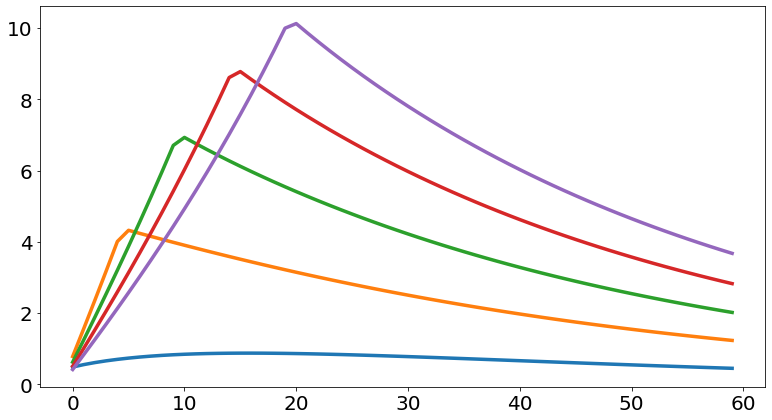

In [23]:
plt.plot(J[:60, [0, 5, 10, 15, 20]]);

# Using this Jacobian to update guesses
Almost instantly converges to something extremely accurate, and gets to 12 decimal places after 6 iterations. **Overwhelmingly** better and more robust than ad-hoc updating!

Asset market clearing up to 12 digits after 6 iterations


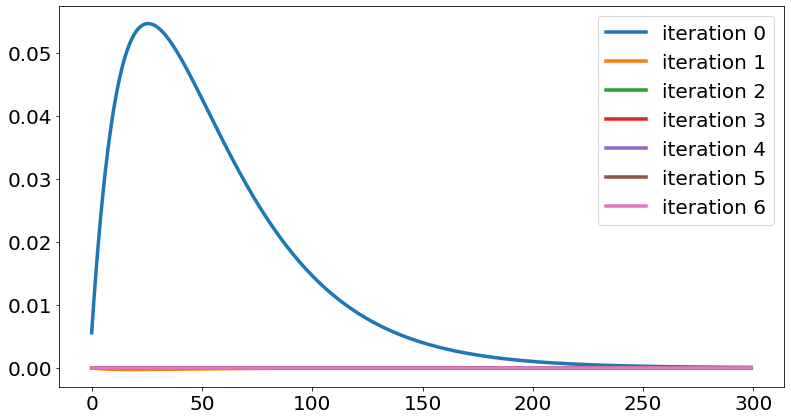

In [24]:
rs = np.full(T, ss_ge['r']) # initial guess constant
Jbar = J[:-1, 1:] # Jbar for our guesses eliminates last row and first column
errs = []
for it in range(30):
    asset_mkt_error, impulse = impulse_map(rs, Xs)
    plt.plot(asset_mkt_error, label=f'iteration {it}')
    err = np.max(np.abs(asset_mkt_error[:-1])) # solve for asset market clearing at 0, 1, ... , T-2
    errs.append(err)
    if err < 1E-10:
        print(f'Asset market clearing up to 12 digits after {it} iterations')
        break
    rs[1:] -= np.linalg.solve(Jbar, asset_mkt_error[:-1]) # adjust r_1, ..., r_(T-1)
plt.legend();

# Speed of convergence
- Plot base-10 logarithm errors by iteration from the last run
- Very fast convergence, albeit asymptotically linear, not quadratic as we hope from Newton's method
- Why? There's some nonlinearity in this economy, so Jacobian around steady state isn't locally exactly accurate around solution

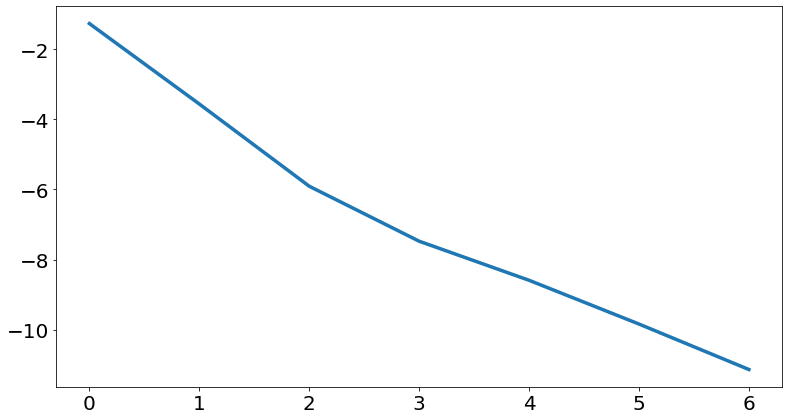

In [25]:
plt.plot(np.log10(np.array(errs)))

# Resulting equilibrium path
- Can see why convergence is unusually tricky in this case: the equilibrium path in the immediate aftermath of the shock is irregularly behaved!


- Why? Probably our budget rule: e.g. $r_0^{ante}=r_1$ falls to encourage consumption at date 0
    * but then when government pays less interest $r_1$ it lowers taxes $\tau_1$...
    * a windfall for some high-MPC agents that encourages them to consume a lot...
    * requiring a big increase in $r_1^{ante}$ to encourage less consumption...
    * and oscillatory behavior continues for a while...
    * hard to capture in an ad-hoc adjustment rule, which is why we needed Jacobian
    
    
- A "better" government budget rule, coupled with more realistic long-term debt, could fix this (you'll see tomorrow), but ad-hoc adjustment still tricky in general

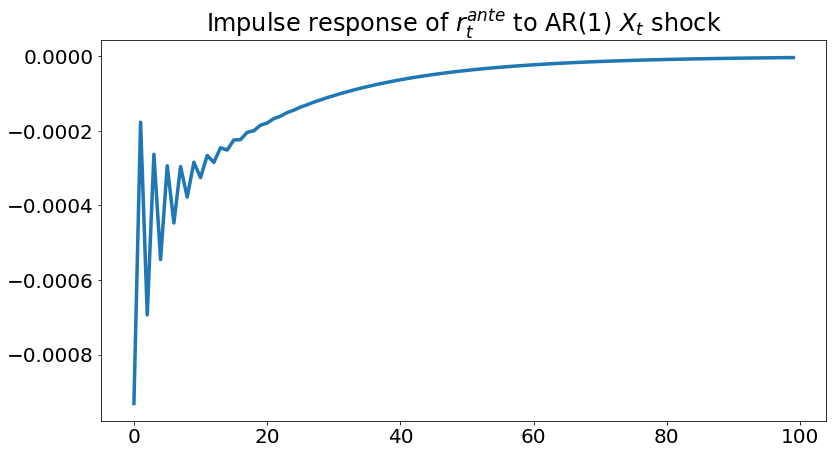

In [26]:
plt.plot(rs[1:101] - ss_ge['r'])
plt.title('Impulse response of $r_t^{ante}$ to AR(1) $X_t$ shock');

# The "fake news algorithm" for sequence-space Jacobians

# Going beyond brute force
- The brute-force ("direct") approach to the Jacobian took 17 seconds - a small price for the benefits it brought us!


- But that only worked because this model isn't too complex, and because our code for it is very fast
    * and because we only needed to compute the Jacobian with respect to one input...


- For more general heterogeneous-agent problems, we want something more efficient
    * this is what we call the "fake news" algorithm

# Insight 1: symmetry in backward iteration
- For brute-force computation of $T\times T$ Jacobian $\mathbf{J}$, we had to compute policy in response to shocks at $s=T-1$, $s=T-2$, $s=T-3$, etc...


- We did a *separate* backward iteration over all $T$ periods for each one of these shocks


- But that was wasteful: the household policy response at date $t$ to a shock at date $s$ is the same as the household policy response at $t-1$ to $s-1$, etc.


- All the matters is the **time until the shock**

# Seeing this for ourselves
Let's do shocks to $r_s$ in `impulse_map` at $s=4$, $s=5$, $s=6$ and look at the asset policy response:

In [27]:
impulse_s4 = (impulse_map(ss_ge['r'] + h*(np.arange(T) == 4), 1)[1]['a'] - ss_ge['a'])/h
impulse_s5 = (impulse_map(ss_ge['r'] + h*(np.arange(T) == 5), 1)[1]['a'] - ss_ge['a'])/h
impulse_s6 = (impulse_map(ss_ge['r'] + h*(np.arange(T) == 6), 1)[1]['a'] - ss_ge['a'])/h

Plot the consumption response at an arbitrary, fixed state `[3,50]` (could be anything), with **number of periods until shock** on horizontal axis. The lines all overlap: *conditional on the number of periods until the shock, the response of the policy function is identical.*

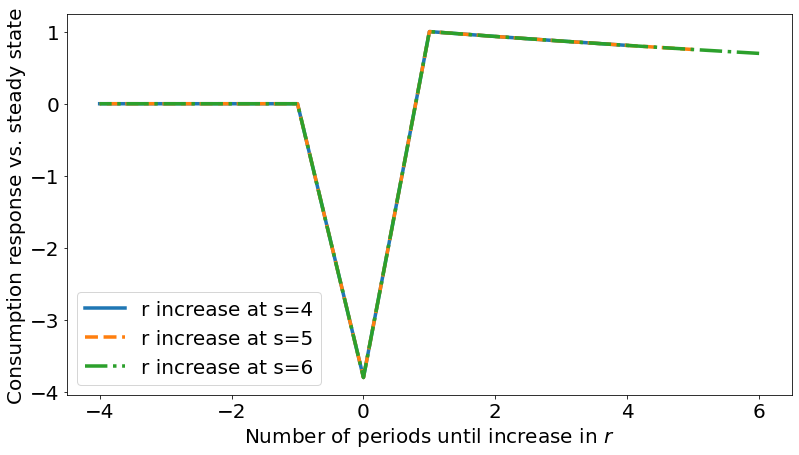

In [28]:
plt.plot(range(4, -5, -1), impulse_s4[:9, 3, 50], label='r increase at s=4')
plt.plot(range(5, -5, -1), impulse_s5[:10, 3, 50], '--', label='r increase at s=5')
plt.plot(range(6, -5, -1), impulse_s6[:11, 3, 50], '-.', label='r increase at s=6')
plt.xlabel(r'Number of periods until increase in $r$')
plt.ylabel('Consumption response vs. steady state')
plt.legend();

# Use this to build Jacobian of `impulse_map`
Assume latest possible shock $dr_{T-1}$, extract policy changes in anticipation:

In [29]:
%%time
da = impulse_map(ss_ge['r'] + h*(np.arange(T) == T-1), 1)[1]['a'] - ss_ge['a']

CPU times: user 61.4 ms, sys: 8.96 ms, total: 70.4 ms
Wall time: 74.4 ms


Now if there's a shock to $dr_s$ at any $s\leq T-1$, we can simulate the policy response just by shifting this over, then computing the distribution, aggregating, and subtracting off what we got with no shock earlier:

In [30]:
%%time
J_alt = np.empty((T, T))
a_ss = np.broadcast_to(ss_ge['a'], da.shape)
for s in range(T):            # for each dr_s from s=0,...,T-1
    a = a_ss.copy()           # start with steady-state asset policy
    a[:s+1] += da[T-1-s:]     # shock at s impacts 'a' up through s, use response to shock at T-1 starting at T-1-s
    D = distribution_impulse(ss_ge, a, T)
    A = np.sum(a*D, axis=(1,2))
    J_alt[:, s] = (A - B - no_shock) / h

CPU times: user 6.08 s, sys: 564 ms, total: 6.65 s
Wall time: 6.81 s


Saved us more than 50% of our time, by avoiding those extra backward iterations! Check to make sure the Jacobian is essentially the same as before, up to numerical error inflated by dividing by $h=0.0001$ (**important**: note that we could do this check even if we had just a few columns of the brute-force Jacobian!):

In [31]:
np.max(np.abs(J_alt - J))

2.6645352591003757e-11

# Where we stand: the value of insight 1
- Economizes on backward iteration: only one backward iteration starting at $T-1$ back to 0, not one for each column of Jacobian


- Already useful here, but not as useful as it could be because our backward iteration code was so fast!
    * In more general cases where backward iteration code much costlier than forward iteration, already a very useful insight


- Remaining cost: still need to do a full run of `distribution_impulse`, simulating distribution from 0 to $T-1$, for all $T$ columns of Jacobian
    * How does distribution evolve in response to a shock at date $s$ we learned about at date 0?
    * Could improve speed further by being cleverer about distribution (no need to re-solve lottery at every step), but we'll take different approach

# Insight 2: difference between $J_{t,s}$ and $J_{t-1,s-1}$
- Insight 1 said there was no difference between **policy** at date $t$ responding to shock at date $s$, and policy at date $t-1$ responding to shock at date $s-1$


- But if we look at $J_{t,s}$ and $J_{t-1,s-1}$, there is a difference, because the *distribution* has evolved differently


- Underlying source of the difference: if at date $t$ responding to shock at date $s$, you *had an extra period of anticipation* to respond vs. if you're at date $t-1$ responding to shock at date $s-1$
    * In this case, you saved more because you knew about higher return another period in advance
    * This effect goes to zero as $t,s\rightarrow \infty$, as example below shows, because anticipation so far in advance doesn't do much

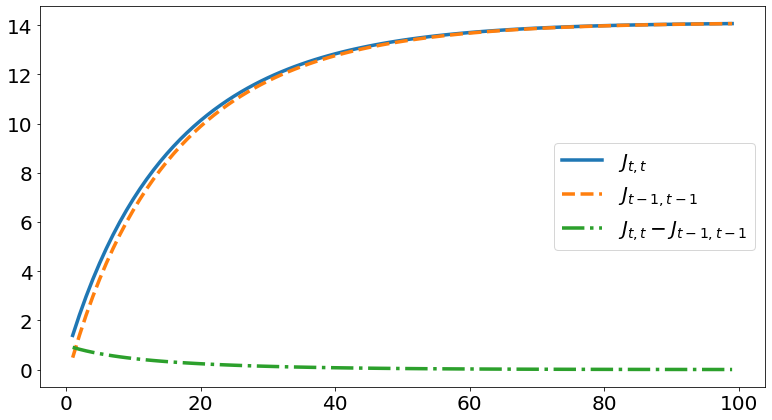

In [32]:
plt.plot(range(1, 100), np.diag(J)[1:100], label='$J_{t,t}$')
plt.plot(range(1, 100), np.diag(J)[:99], '--', label='$J_{t-1,t-1}$')
plt.plot(range(1, 100), np.diag(J)[1:100] - np.diag(J)[:99], '-.', label='$J_{t,t} - J_{t-1,t-1}$')
plt.legend();

# Other way to see this: plotting columns of $J$
Eventually, they converge to the same shape, just shifting to right, as $J_{t,s} - J_{t-1,s-1} \rightarrow 0$

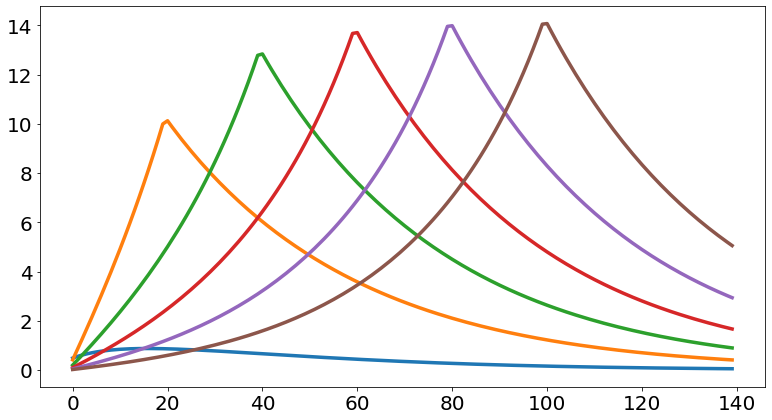

In [33]:
plt.plot(J[:140, [0, 20, 40, 60, 80, 100]]);

# Insight 2 continued: $F_{t,s}\equiv J_{t,s} - J_{t-1,s-1}$ represents effect of anticipation
- Claim: $F_{t,s} \equiv J_{t,s} - J_{t-1,s-1}$ represents *extra* effect of anticipating, at date 0, that there will be an increase in $r$ at date $s$ 
    * Otherwise the two are symmetric: anticipation of $s-1$ shock at date 0 is same as anticipation of $s$ shock at date 1, and so on...
    * But that extra anticipation, in this case, will mean more savings, which persists over time...


- By insight 1, policy effect of anticipating $s$ shock at date 0 equals policy effect of anticipating $T-1$ shock at date $T-1-s$, which we already calculated as `da[T-1-s]`
    * Let's calculate impulse to this change in asset policy at date 0 alone, for $s=10$, and verify this claim

In [34]:
a = a_ss.copy()
a[0] += da[T-1-10] # only shock is to asset policy at date 0 from anticipating s=10 then, nothing else
D = distribution_impulse(ss_ge, a, T)
A = np.sum(a*D, axis=(1,2))
anticipation_effect = (A - B - no_shock) / h

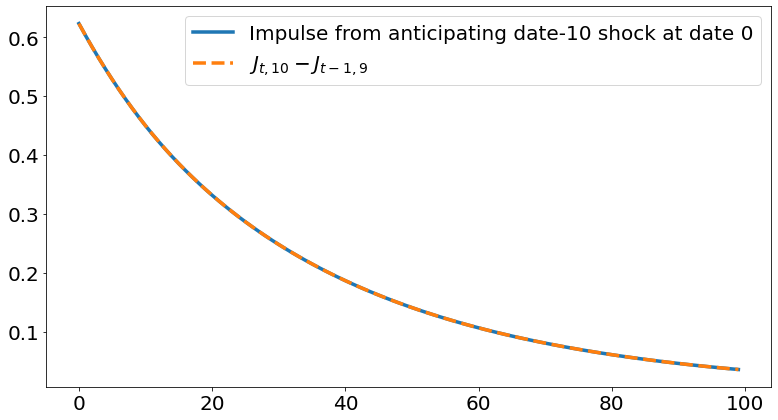

In [35]:
plt.plot(anticipation_effect[:100], label='Impulse from anticipating date-10 shock at date 0')
F = J.copy()
F[1:, 1:] -= J[:-1, :-1]
plt.plot(F[:100, 10], '--', label='$J_{t, 10} - J_{t-1, 9}$')
plt.legend();

# Calculating entire Jacobian using this insight

- Verify we can calculate the matrix $F_{t,s} \equiv J_{t,s} - J_{t-1,s-1}$ this way, with small error
    * We expect some disagreement because $J_{t,s}$ obtained using numerical differentiation

In [36]:
%%time
F_alt = np.empty((T,T))
for s in range(T):
    # calculate impulse response to anticipation of date-s shock at date 0
    a = a_ss.copy()
    a[0] += da[T-1-s] 
    D = distribution_impulse(ss_ge, a, T)
    A = np.sum(a*D, axis=(1,2))
    F_alt[:, s] = (A - B - no_shock) / h
np.max(np.abs(F_alt - F))

CPU times: user 6.05 s, sys: 587 ms, total: 6.64 s
Wall time: 6.8 s


6.712085109938926e-05

- To build up $J$ from $F$, can recursively sum along diagonals:

In [37]:
def J_from_F(F):
    J = F.copy()
    for t in range(1, F.shape[0]):
        J[1:, t] += J[:-1, t-1]
    return J

In [38]:
np.array_equal(J_from_F(F), J)

True

# Where we stand after insight 2
- We've showed that we can relate $\mathbf{J}$ to a simpler matrix $\mathbf{F}$, whose column $s$ represents only the effect of date-0 anticipation of a date-$s$ shock


- Interpretation of $F_{t,s} = J_{t,s} - J_{t-1,s-1}$:
    * learn at date 0 there will be a shock at date $s$ ($J_{t,s}$)
    * learn at date 1 there won't be a shock at date $s$ after all ($-J_{t-1,s-1}$)
    * ... or, this is the impulse response to a "fake news shock" (and we call $\mathbf{F}$ the "fake news matrix")
    
    
- Calculating $\mathbf{F}$ gives us $\mathbf{J}$, but $\mathbf{F}$ still fairly expensive (7 seconds)
    * similar bottleneck to before: **iterating forward on distribution** after date-0 anticipation perturbs it

# Insight 3: don't iterate on distribution, use expectation functions
- The asset policy change at date 0 causes the distribution at beginning of date 1 to be different


- Policies back to steady state after that, but different date-1 distribution causes persistent effects


- But we already know how to calculate the persistent effects of a change in distribution: **expectation functions**!
    * Tell us expectation of future at each state today
    * Aggregating across distribution of states today, we get expectation of aggregate future
    * This equals actual future, since we're doing perfect foresight

# Refresher: calculate expectation functions at each horizon
Almost instant to do this (once initial cost of Numba compilation is paid):

In [39]:
sim.expectation_functions(ss_ge['a'], ss_ge['Pi'], ss_ge['a_i'], ss_ge['a_pi'], T)
%time curlyE = sim.expectation_functions(ss_ge['a'], ss_ge['Pi'], ss_ge['a_i'], ss_ge['a_pi'], T)

CPU times: user 10.3 ms, sys: 290 µs, total: 10.6 ms
Wall time: 11.8 ms


This gives us expected asset value at each horizon for someone in a given state today. For instance, let's plot trajectory of expected assets for people with middle incomes and various levels of assets today:

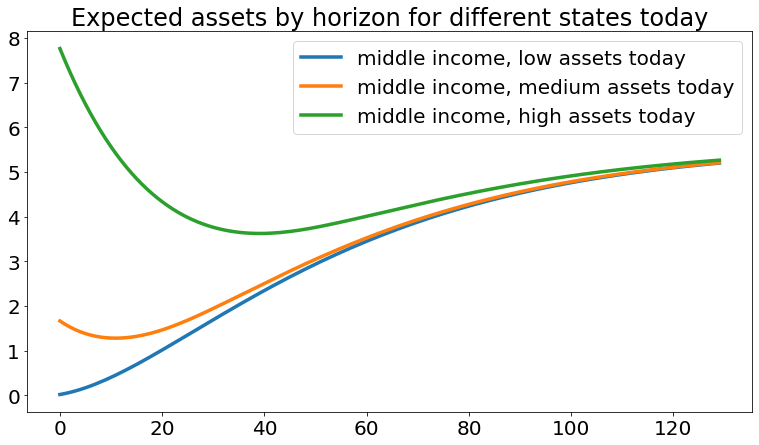

In [40]:
plt.plot(curlyE[:130, 3, 0], label='middle income, low assets today')
plt.plot(curlyE[:130, 3, 150], label='middle income, medium assets today')
plt.plot(curlyE[:130, 3, 250], label='middle income, high assets today')
plt.title('Expected assets by horizon for different states today')
plt.legend();

# Full "fake news algorithm": build entire F matrix with this, get J

In [41]:
%%time
F = np.empty((T,T))
D1_noshock = sim.forward_iteration(ss_ge['D'], ss_ge['Pi'], ss_ge['a_i'], ss_ge['a_pi'])
for s in range(T):
    # F_(0,s): change in asset policy times steady-state incoming distribution
    F[0, s] = np.vdot(ss_ge['D'], da[T-1-s]) / h
    
    # change in D_1 from this change
    a_i_shocked, a_pi_shocked = sim.interpolate_lottery_loop(ss_ge['a'] + da[T-1-s], ss_ge['a_grid'])
    dD1 = sim.forward_iteration(ss_ge['D'], ss_ge['Pi'], a_i_shocked, a_pi_shocked) - D1_noshock
    
    # use expectation vectors to project effect on aggregate
    F[1:, s] = (curlyE[:T-1].reshape(T-1, -1) @ dD1.ravel()) / h

J_alt = J_from_F(F)

CPU times: user 394 ms, sys: 6.8 ms, total: 401 ms
Wall time: 220 ms


- That (even combined with our previous steps) only took a quarter of a second! Check that it's correct:

In [42]:
np.max(np.abs(J_alt - J))

0.0017242891081945544

- Some not-too-large error from nonlinearities and numerical differentiation
    * Have shown in SSJ paper that fake news algorithm actually more accurate than brute-force, so this error is more the fault of our benchmark

# Summary: four steps to fake news algorithm
We did case where only shocked input was $i=r$ and policy of interest was $o=a$, but more generally with many $i$ and $o$:

- **Step 1:** for each $i$, iterate backward from shock at $T-1$ to find:
    * effect on policies $o$, aggregated using steady-state distribution, at each horizon $s$, stored in $\mathcal{Y}_s^{o,i}$
    * effect on one-period-ahead distribution at each horizon $s$, stored in $\mathcal{D}_s^{i}$
    
    
- **Step 2:** for each $o$, do expectations iteration to obtain expectation functions at horizons $t$ up to $T-2$, store in $\mathcal{E}_t^o$


- **Step 3:** assemble fake news matrix $\mathbf{F}^{o,i}$ for each pair $(o,i)$ using

$$
F_{t,s}^{o,i} = 
\begin{cases}
\mathcal{Y}_s^{o,i} & t = 0 \\
(\mathcal{E}_{t-1}^o)'\mathcal{D}_s^i & t > 0
\end{cases}
$$

- **Step 4:** Use recursion

$$
J_{t,s}^{o,i} =
\begin{cases}
J_{t-1,s-1}^{o,i} + F_{t,s}^{o,i} & t,s>0 \\
F_{t,s}^{o,i} & \text{otherwise}
\end{cases}
$$

# General code for step 1 for outputs $o\in {a,c}$, any input shock

In [43]:
def step1_backward(ss, shock, T, h):
    # preliminaries: D_1 with no shock, ss inputs to backward_iteration
    D1_noshock = sim.forward_iteration(ss['D'], ss['Pi'], ss['a_i'], ss['a_pi'])
    ss_inputs = {k: ss[k] for k in ('Va', 'Pi', 'a_grid', 'y', 'r', 'beta', 'eis')}
    
    # allocate space for results
    curlyY = {'A': np.empty(T), 'C': np.empty(T)}
    curlyD = np.empty((T,) + ss['D'].shape)
    
    # backward iterate
    for s in range(T):
        if s == 0:
            # at horizon of s=0, 'shock' actually hits, override ss_inputs with shock
            shocked_inputs = {k: ss[k] + h*shock[k] for k in shock}
            Va, a, c = sim.backward_iteration(**{**ss_inputs, **shocked_inputs})
        else:
            # now the only effect is anticipation, so it's just Va being different
            Va, a, c = sim.backward_iteration(**{**ss_inputs, 'Va': Va})
        
        # aggregate effects on A and C
        curlyY['A'][s] = np.vdot(ss['D'], a - ss['a']) / h
        curlyY['C'][s] = np.vdot(ss['D'], c - ss['c']) / h
        
        # what is effect on one-period-ahead distribution?
        a_i_shocked, a_pi_shocked = sim.interpolate_lottery_loop(a, ss['a_grid'])
        curlyD[s] = (sim.forward_iteration(ss_ge['D'], ss_ge['Pi'], a_i_shocked, a_pi_shocked) - D1_noshock) / h
        
    return curlyY, curlyD

# Putting all four steps together

In [44]:
def jacobian(ss, shocks, T):
    # step 1 for all shocks i, allocate to curlyY[o][i] and curlyD[i]
    curlyY = {'A': {}, 'C': {}}
    curlyD = {}
    for i, shock in shocks.items():
        curlyYi, curlyD[i] = step1_backward(ss, shock, T, 1E-4)
        curlyY['A'][i], curlyY['C'][i] = curlyYi['A'], curlyYi['C']
    
    # step 2 for all outputs o of interest (here A and C)
    curlyE = {}
    for o in ('A', 'C'):
        curlyE[o] = sim.expectation_functions(ss[o.lower()], ss['Pi'], ss['a_i'], ss['a_pi'], T-1)
                                            
    # steps 3 and 4: build fake news matrices, convert to Jacobians
    Js = {'A': {}, 'C': {}}
    for o in Js:
        for i in shocks:
            F = np.empty((T, T))
            F[0, :] = curlyY[o][i]
            F[1:, :] = curlyE[o].reshape(T-1, -1) @ curlyD[i].reshape(T, -1).T
            Js[o][i] = J_from_F(F)
    
    return Js

# Let's apply it!
- Generalize $y_t(s) \equiv (X_t - \tau_t)e(s) + T_t$, where $X \equiv 1$ and $T\equiv 0$ in steady state



- Can think of assets at each $t$ as function $\mathcal{A}_t(\{r_s\}, \{X_s-\tau_s\}, \{T_s\})$, which all enter directly into household problem, similarly for consumption $\mathcal{C}_t(\{r_s\}, \{X_s-\tau_s\}, \{T_s\})$



- Calculate sequence-space Jacobians of $\mathcal{A}$ and $\mathcal{C}$ with respect to $r$, $X-\tau$, and $T$
    * Note that Jacobian with respect to $r$ here is *only* direct effect, not indirect effect from earlier    
    
    
- Extreme speed: **Just a quarter of a second for all three!**

In [45]:
%time Js = jacobian(ss_ge, {'r_direct': {'r': 1}, 'X': {'y': e}, 'T': {'y': np.ones_like(e)}}, T)

CPU times: user 397 ms, sys: 34.1 ms, total: 431 ms
Wall time: 368 ms


Let's validate by comparing to our previous Jacobians that included indirect effects of $r$, which worked through $d\tau_t = -B dr_t$, for which we also know the Jacobian

In [46]:
J_alt2 = Js['A']['r_direct'] - B*Js['A']['X']
# compare to original brute-force Jacobian, fake-news Jacobian
np.max(np.abs(J_alt2 - J)), np.max(np.abs(J_alt2 - J_alt))

(0.0016710429250608172, 0.000266007744471608)

# Example Jacobian: proportional shock to incomes, effect on assets
Proportionally shock incomes by shocking $X_s-\tau_s$. Asset effect: dissave in anticipation, disaccumulate afterward (here shocks at $s=0,10,20$)

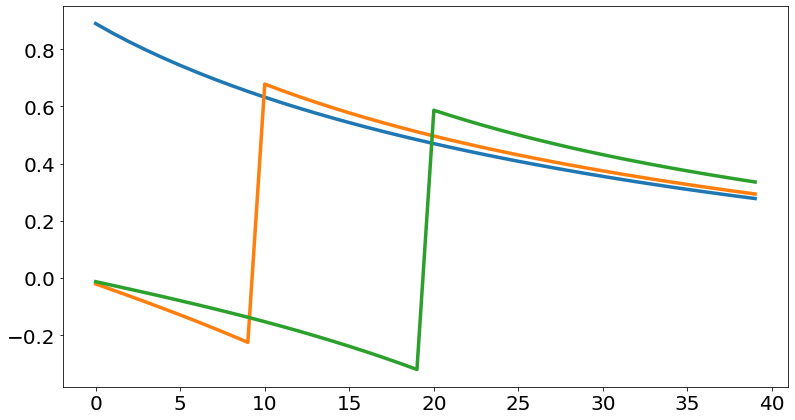

In [47]:
plt.plot(Js['A']['X'][:40, [0, 10, 20]]);

# Example Jacobian: proportional shock to incomes, effect on consumption
Spike in consumption at receipt, spending before and after

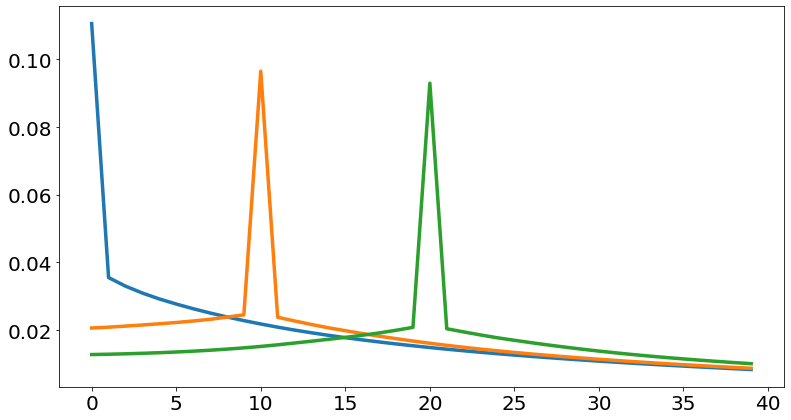

In [48]:
plt.plot(Js['C']['X'][:40, [0, 10, 20]]);

# Example Jacobian: equal shock to incomes, effect on consumption
Bigger spike at receipt, more anticipatory spending (gives more to low-income, high-MPC households, and acts as a form of insurance ex ante, displacing precautionary savings)

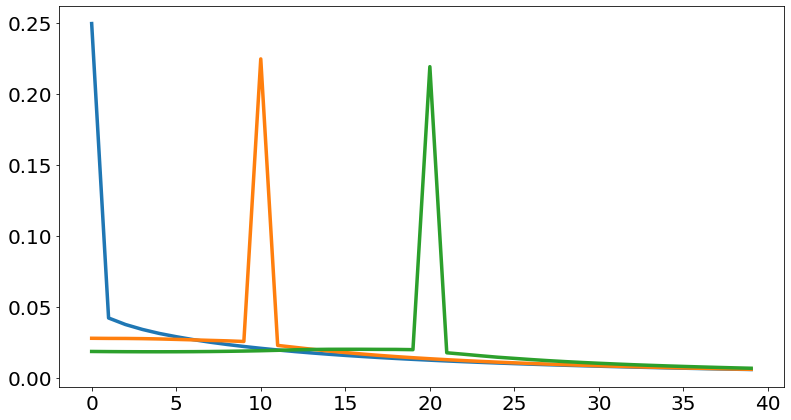

In [49]:
plt.plot(Js['C']['T'][:40, [0, 10, 20]]);

# General equilibrium Jacobians

# General equilibrium Jacobians: solving a linear "sequence-space" system
- Asset market clearing is, substituting $\tau_s = r_sB$

$$
\mathcal{A}_t(\{r_s\}, \{X_s-r_sB\}) = B
$$


- Truncate and apply implicit function theorem: in response to exogenous $\{dX_s\}$ shock, we have

$$
d\mathbf{r} = -(\bar{J}_{\mathcal{A}, r} - B\bar{J}_{\mathcal{A}, X})^{-1} J_{\mathcal{A}, Z}d\mathbf{X}
$$

- where $d\mathbf{r} = (dr_1,\ldots,dr_{T-1})$, $d\mathbf{X} = (dX_0,\ldots,dX_{T-2})$, $J$ are Jacobians from $0,\ldots,T-2$ to $0,\ldots,T-2$ and $\bar{J}$ are Jacobians from $1,\ldots,T-1$ to $0,\ldots,T-2$
    * (usually easier than this, but we have the timing issue where $dr_0$ doesn't move)
    

- Define $G_{r,X}\equiv -(\bar{J}_{\mathcal{A}, r} - \bar{J}_{\mathcal{A}, X})^{-1} J_{\mathcal{A}, X}$ to be the **general equilibrium Jacobian** mapping all $d\mathbf{X}$ shocks to $d\mathbf{r}$

# Solve for general equilibrium Jacobian

In [50]:
G = -np.linalg.solve(Js['A']['r_direct'][:-1, 1:] - B*Js['A']['X'][:-1, 1:], Js['A']['X'][:-1, :-1]) 

Plot some columns of this matrix: GE $r$ impulses to one-time $X_s$ increases at various $s$. In this case, we see the same messy response as before (due to strong indirect effects of $r$ affecting taxation):

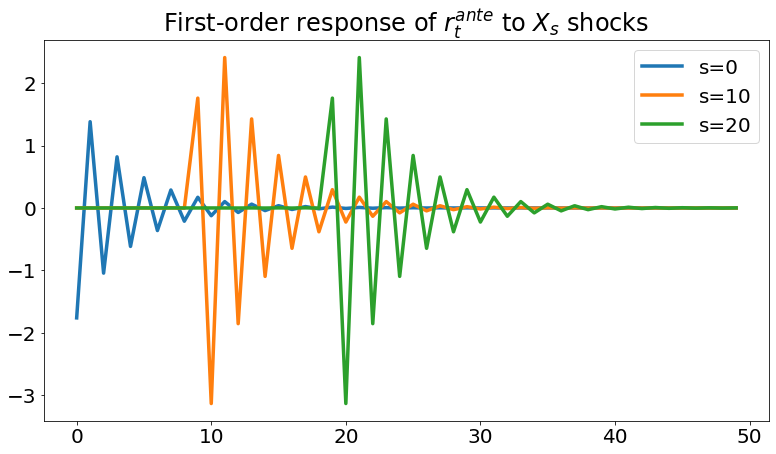

In [51]:
plt.plot(G[:50, [0, 10, 20]])
plt.legend(['s=0', 's=10', 's=20'])
plt.title('First-order response of $r^{ante}_t$ to $X_s$ shocks');

# Mix-and-match into different AR(1)s
- Beauty of GE Jacobians is that they give us first-order impulse response to shocks at **every horizon simultaneously**


- Can exploit linearity to find impulse responses to, say, AR(1)s with different persistences, all pretty much instantaneously:

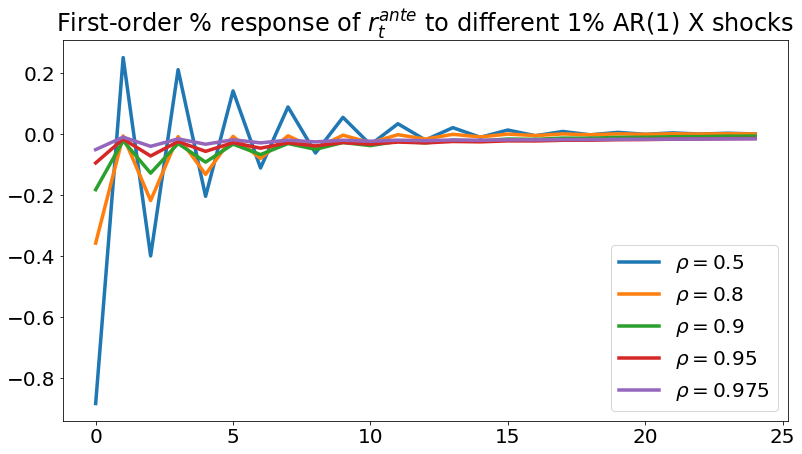

In [52]:
rhos = np.array([0.5, 0.8, 0.9, 0.95, 0.975])
dXs = rhos**np.arange(T-1)[:, np.newaxis] # each column is a dX impulse with different persistence
drs = G @ dXs # simple command obtains impulses to all these simultaneously!
plt.plot(drs[:25])
plt.legend([fr'$\rho={rho}$' for rho in rhos])
plt.title('First-order % response of $r^{ante}_t$ to different 1% AR(1) X shocks');

# Stochastic economies: certainty equivalence, simulation, and second moments

# First-order impulse responses and simulation of stochastic economy
- Suppose that $dX_t$ follows an AR(1) process with $\epsilon_t \sim \mathcal{N}(0,1)$

$$
dX_t = \rho dX_{t-1} + \sigma\epsilon_t
$$


- **Certainty equivalence**: linearizing economy to first order in aggregates, the impulse response to an $\epsilon$ innovation is the same as the impulse response to the MIT shock $(dX_0,dX_1,\ldots) = \epsilon\cdot(\sigma,\rho\sigma,\rho^2\sigma\ldots)$


- Can stitch together these impulses to get a simulated path!


- Concretely, if we calculate that impulse response of some outcome $Y$ to an $\epsilon$ innovation is $(a_0,a_1,\ldots,a_{T-1})$, can calculate stochastic process $dY_t$  as
$$dY_t = \sum_{s=0}^{T-1}a_s \epsilon_{t-s}$$


- Could combine more than one shock (just sum them together), or have more complicated process, too

# Implement this to simulate

$$dY_t = \sum_{s=0}^{T-1}a_s \epsilon_{t-s}$$

In [53]:
@numba.njit(parallel=True)
def simul_shock(a, epsilons):
    """Take in any impulse response a to epsilon shock, plus path of epsilons, and simulate"""    
    # if I have T_simul epsilons, can simulate length T_simul - T + 1 dY
    # by indexing as eps_(-T-1), ... , eps_(T_simul-T+1) and implementing formula
    T = len(a)
    T_simul = len(epsilons)
    dY = np.empty(T_simul - T + 1) 
    
    a_flipped = a[::-1].copy() # flip because a_s multiplies eps_(t-s)
    for t in numba.prange(T_simul - T + 1):
        dY[t] = np.vdot(a_flipped, epsilons[t:t + T]) # sum as single dot product

    return dY

- Setting $Y=r^{ante}$, let's simulate a time series of 10000 $\{dr_t^{ante}\}$, assuming $\rho=0.8$ (second column of our `drs`) and $\sigma=0.01$. Takes a few milliseconds combining cost of random normal draws, and simulation given them.

In [54]:
%time epsilons = np.random.randn(10_000 + len(G) - 1)
simul_shock(0.01*drs[:, 1], epsilons) # burn-in Numba
%time dr_simulated = simul_shock(0.01*drs[:, 1], epsilons)

CPU times: user 1.3 ms, sys: 2.04 ms, total: 3.35 ms
Wall time: 6.57 ms
CPU times: user 1.33 ms, sys: 177 µs, total: 1.51 ms
Wall time: 943 µs


# Plot simulation

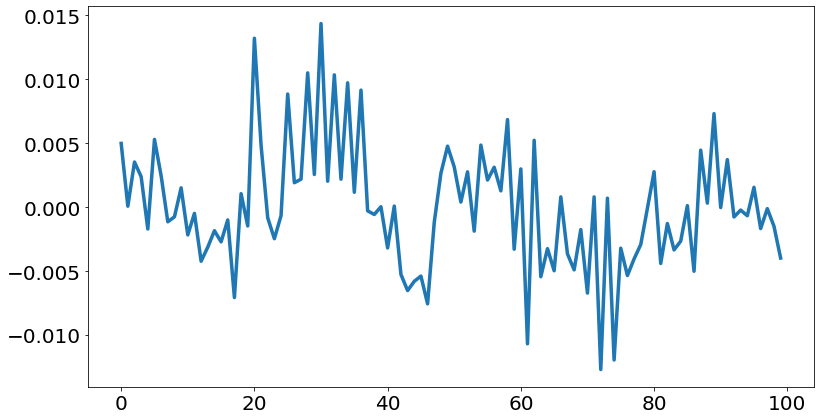

In [55]:
plt.plot(dr_simulated[:100]);

# Second moments: no need to simulate!
- Suppose we want to find some theoretical autocovariances of some $dY_t$. **Don't need to calculate on simulated data!** Simple standard expression:

$$
\text{Cov}(dY_t,dY_{t'}) \equiv \gamma_{t'-t}= \sum_{s=0}^{T-1-(t'-t)}a_s a_{s+t'-t}
$$


- Direct, brute-force implementation of this and application to our case:

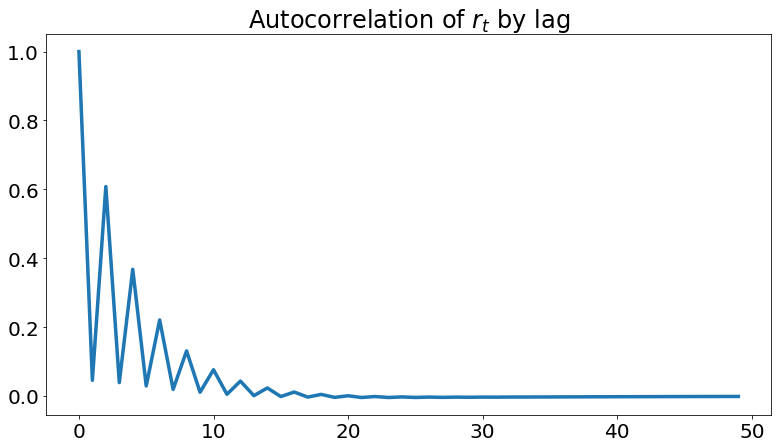

In [56]:
def autocovariances(a):
    T = len(a)
    return np.array(
        [sum(a[s]*a[s+dt] for s in range(T-dt)) for dt in range(T)])

gammas = autocovariances(0.01*drs[:, 1])
plt.plot(gammas[:50] / gammas[0])
plt.title('Autocorrelation of $r_t$ by lag');

# Compare these second moments to ones from simulated data

Simple calculation taking second moment at various lags of simulated data to get autocovariance.

(This assumes mean is zero, we could correct for sample mean not being exactly zero, but that turns out to matter very little here.)

In [57]:
T_sim = len(dr_simulated)
gammas_simulated = np.array([np.vdot(dr_simulated[dt:], dr_simulated[:T_sim-dt])/(T_sim-dt) for dt in range(len(drs))])

Plot theoretical autocorrelation from before against this autocorrelation from simulated data. They agree pretty well (verifying that our theoretical calculation was reasonable!), but some jitter at long horizons in the simulated data, so theoretical is clearly a lot more accurate:

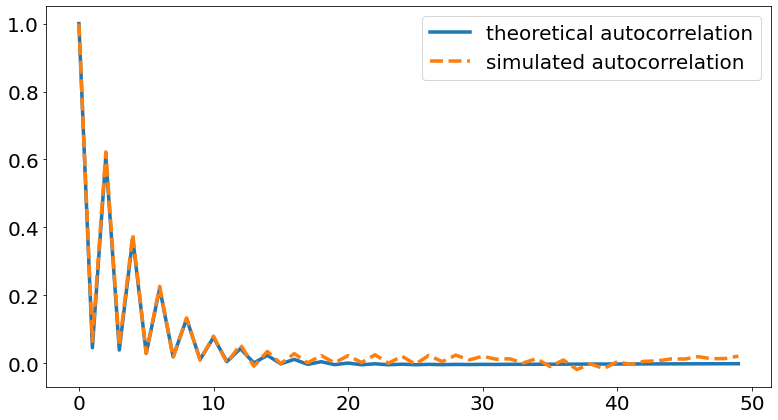

In [58]:
plt.plot(gammas[:50] / gammas[0], label='theoretical autocorrelation')
plt.plot(gammas_simulated[:50] / gammas_simulated[0], '--', label='simulated autocorrelation')
plt.legend();

# Can do better using the FFT
The following code uses the Fast Fourier Transform (FFT) to take autocovariances very quickly. Applies to *general case* where we're interested in $n_Y$ different variables and $n_X$ different shocks, and `a` is $T\times n_Y \times n_X$:

In [59]:
def autocovariances_fft(a):
    T = len(a)
    dft = np.fft.rfftn(a, s=(2 * T - 1,), axes=(0,))
    total = dft.conjugate() @ dft.swapaxes(1, 2)
    return np.fft.irfftn(total, s=(2 * T - 1,), axes=(0,))[:T]

Test that it gives same result as brute-force, now in less than a millisecond (note we need to add singleton dimensions $n_Y=1$ and $n_X=1$:

In [60]:
%time gammas_new = autocovariances_fft(0.01*drs[:, 1][:, np.newaxis, np.newaxis]).squeeze()
np.max(np.abs(gammas_new - gammas))

CPU times: user 1.12 ms, sys: 455 µs, total: 1.58 ms
Wall time: 4.4 ms


1.1858461261560205e-20

# More general case: multiple shocks, multiple observables

- Let's try this function for $n_Y>1$ and $n_X>1$
- Suppose now that $dX_t$ is a mixture of all five AR(1) components with $\rho=0.5, 0.8, 0.9, 0.95, 0.975$ whose impulses we calculated, each with amplitude 0.01 (so $n_X = 5$)
- Also suppose we're interested in both $dX_t$ and $dr_t^{ante}$, and the cross-autocovariances between them (so $n_Y=2$)

In [61]:
# make T * n_Y * n_X array of impulse responses of outcomes of interest vs. shocks
a = 0.01*np.swapaxes(np.stack([dXs, drs]), 0, 1)
a.shape

(299, 2, 5)

In [64]:
%time gammas = autocovariances_fft(a)

CPU times: user 1.02 ms, sys: 35 µs, total: 1.05 ms
Wall time: 1.06 ms


Let's plot! Note that in general `gammas[s, b, c]` gives covariance between $b_t$ and $c_{t+s}$:

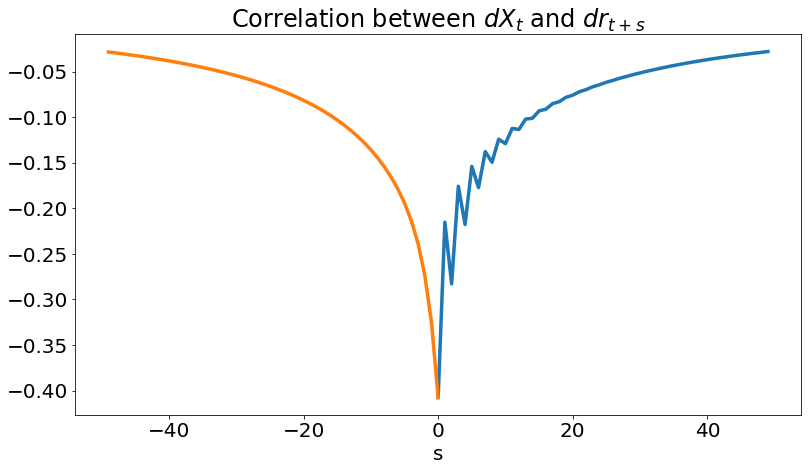

In [65]:
plt.plot(np.arange(50), gammas[:50, 0, 1] / np.sqrt(gammas[0, 0, 0]*gammas[0, 1, 1]))
plt.plot(-np.arange(50), gammas[:50, 1, 0] / np.sqrt(gammas[0, 0, 0]*gammas[0, 1, 1])) 
plt.title('Correlation between $dX_t$ and $dr_{t+s}$')
plt.xlabel('s');

# Taking stock

- Partial equilibrium dynamics in response to "MIT shocks": simple


- General equilibrium dynamics in response to "MIT shocks": difficult with ad-hoc iteration, easy with sequence-space Jacobians


- Fast "fake news" algorithm for sequence-space Jacobians


- Can solve linear sequence-space system directly to obtain first-order impulse responses to shocks


- ... and use these first-order impulse responses to fully characterize dynamics of stochastic economy, including second moments!